In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
import scipy.stats
import gzip
from tqdm.auto import tqdm
from utils import fit_exp

from sklearn import ensemble, datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [98]:
yahist.utils.set_default_style()

In [3]:
data_dir = "../sources/healthweather/data"
state_abbrevs = "AL AZ AR CA CO CT DE FL GA ID IL IN IA KS KY LA ME MD MA MI MN MS MO MT NE NV NH NJ NM NY NC ND OH OK OR PA RI SC SD TN TX UT VT VA WA WV WI WY".split()

def get_df(state="CA"):
    js = json.load(gzip.open(f"{data_dir}/states/{state}_data.json.gz"))
    dfc = pd.DataFrame(js["data"], columns=js["columns"])
    dfc["date"] = pd.to_datetime(dfc["date"])
    dfc = dfc.set_index("date")
    dfc["days_ago"] = -(dfc.index - pd.Timestamp.now()).total_seconds()/86400
    dfc["region_name"] = dfc["region_name"].str.replace(" County","",1)
    return dfc

dfc = get_df("CA")
dfc.head()

,region_id,region_name,state,observed_ili,atypical_ili,anomaly_diff,forecast_expected,forecast_lower,forecast_upper,days_ago
date,,,,,,,,,,
2020-02-16,06045,Mendocino,CA,6.162216,NaN,0.0,NaN,NaN,NaN,40.777935
2020-02-16,06047,Merced,CA,6.670193,NaN,0.0,NaN,NaN,NaN,40.777935
2020-02-16,06043,Mariposa,CA,6.456185,NaN,NaN,NaN,NaN,NaN,40.777935
2020-02-16,06051,Mono,CA,6.478310,NaN,NaN,NaN,NaN,NaN,40.777935
2020-02-16,06013,Contra Costa,CA,6.626920,NaN,0.0,NaN,NaN,NaN,40.777935


In [4]:
df_cases_raw = pd.read_json("../sources/1point3acres/data/cases_and_deaths.json.gz").query("not is_death")
df_cases_raw["date"] = pd.to_datetime(df_cases_raw["date"])
# Require state abbreviation to be length 2 (otherwise diamond princess/etc would get included)
df_cases = df_cases_raw[df_cases_raw["state"].str.len() == 2]
df_cases = df_cases.groupby(["state","county"])[["ngroup"]].count().reset_index().rename({"ngroup":"cases"},axis=1)
print(len(df_cases))
df_cases.head()

1728


,state,county,cases
0,AK,Anchorage,30
1,AK,Eagle River,3
2,AK,Fairbanks North Star,10
3,AK,Homer,1
4,AK,Juneau,3


In [130]:
dfs = []
for state in tqdm(state_abbrevs):
    dfstate = get_df(state)
    ndays = 10
    dfstate = dfstate[~dfstate[["forecast_expected","observed_ili"]].isna().any(axis=1)].query(f"days_ago<{ndays+1}")
    dfstate = dfstate.sort_index()
    data = []
    for name,group in dfstate.groupby("region_name"):
        group = group.reset_index()
        features = dict()
        features["state"] = state
        features["county"] = name
        for md,exp,upper,obs in zip(group["date"].dt.strftime("%m%d"),
                              group["forecast_expected"].values,
                              group["forecast_upper"].values,
                              group["observed_ili"].values):
            experr = upper-exp
#             features[f"feat_{md}_obs"] = obs
#             features[f"feat_{md}_exp"] = exp
            features[f"feat_{md}_z"] = (obs-exp)/experr
        data.append(features)
    df = pd.DataFrame(data)
    dfs.append(df)
    
dftot = pd.concat(dfs)
dftot.head()

,state,county,feat_0317_z,feat_0318_z,feat_0319_z,feat_0320_z,feat_0321_z,feat_0322_z,feat_0323_z,feat_0324_z,feat_0325_z,feat_0326_z
0,AL,Autauga,2.367736,2.261526,2.154745,2.079693,1.585173,1.502081,1.478199,1.123467,0.825403,0.811937
1,AL,Baldwin,2.328695,2.346410,2.476273,1.919975,1.717994,1.675160,1.373442,1.280583,0.745461,0.828829
2,AL,Barbour,2.385062,2.673092,2.588610,2.471031,1.679661,1.632060,1.638404,1.171591,0.563239,0.291626
3,AL,Bibb,2.021060,2.037975,2.172893,2.191739,1.411845,1.276229,1.411956,1.022689,0.947610,0.845016
4,AL,Blount,1.823077,1.900840,1.830063,2.143218,1.493441,1.299909,1.366076,1.120422,0.701439,0.667238


In [131]:
# merge cases and z-scores
dftot = dftot.merge(df_cases, how="left", on=["state","county"]).fillna(0)

# merge in population
df_pop = pd.read_json("../sources/census/data/county_populations.json.gz")
df_pop["county"] = (df_pop["county"]
                   .str.replace(" Municipality","")
                   .str.replace(" County","")
                   .str.replace(" Borough","")
                   .str.replace(" Parish","")
                   .str.replace(" city","",case=True))
dftot = dftot.merge(df_pop,on=["state","county"], how="inner")

print(len(dftot))
dftot.head()

3003


,state,county,feat_0317_z,feat_0318_z,feat_0319_z,feat_0320_z,feat_0321_z,feat_0322_z,feat_0323_z,feat_0324_z,feat_0325_z,feat_0326_z,cases,population
0,AL,Autauga,2.367736,2.261526,2.154745,2.079693,1.585173,1.502081,1.478199,1.123467,0.825403,0.811937,6.0,55869
1,AL,Baldwin,2.328695,2.346410,2.476273,1.919975,1.717994,1.675160,1.373442,1.280583,0.745461,0.828829,5.0,223234
2,AL,Barbour,2.385062,2.673092,2.588610,2.471031,1.679661,1.632060,1.638404,1.171591,0.563239,0.291626,0.0,24686
3,AL,Bibb,2.021060,2.037975,2.172893,2.191739,1.411845,1.276229,1.411956,1.022689,0.947610,0.845016,0.0,22394
4,AL,Blount,1.823077,1.900840,1.830063,2.143218,1.493441,1.299909,1.366076,1.120422,0.701439,0.667238,3.0,57826


In [132]:
X = dftot.filter(like="feat_",axis=1)
# y = np.log10(dftot["population"]+1) # 0 cases -> 1 case to avoid -inf
y = np.log10(dftot["cases"]+1) # 0 cases -> 1 case to avoid -inf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46, )

In [133]:

params = {'n_estimators': 150, 'max_depth': 4}
clf = ensemble.GradientBoostingRegressor(**params)
# clf = ensemble.GradientBoostingRegressor()
clf.fit(X_train, y_train)

mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.3849


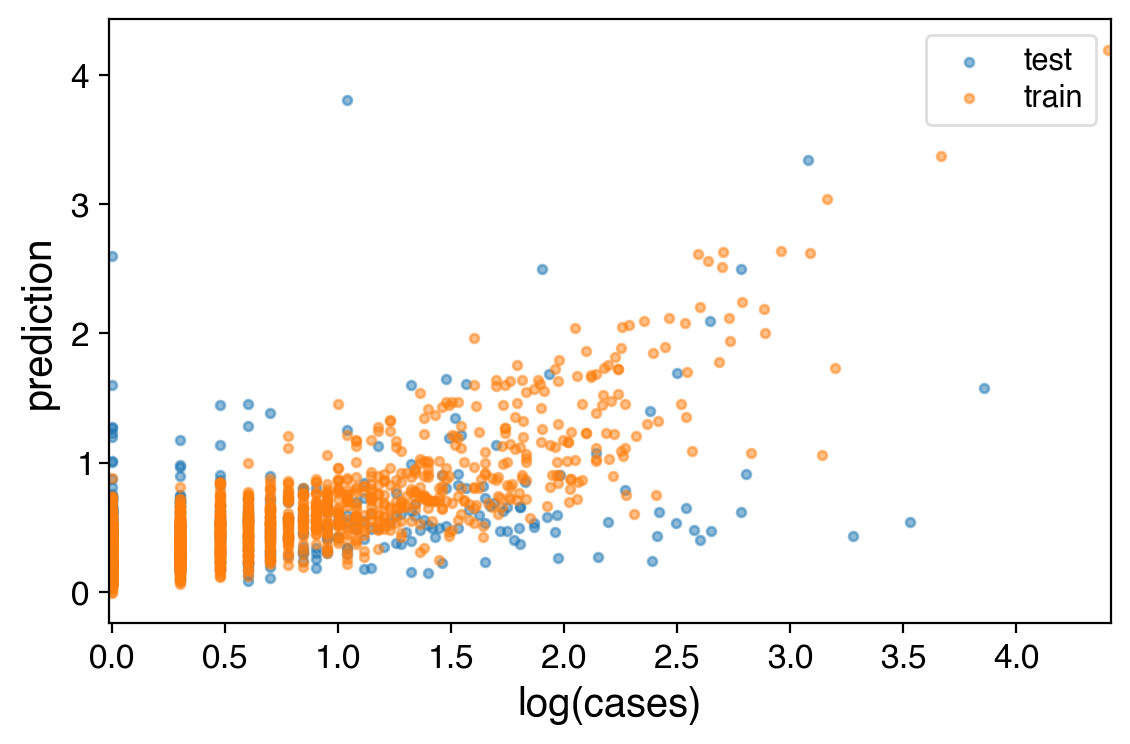

In [140]:
plt.scatter(
    y_test,
    clf.predict(X_test),
    alpha=0.5,
    s=10.,
    label="test",
)
    
plt.scatter(
    y_train,
    clf.predict(X_train),
    alpha=0.5,
    s=10.,
    label="train",
)

plt.xlabel("log(cases)")
plt.ylabel("prediction")
    
plt.legend()

Text(0.5, 1.0, 'Variable Importance')

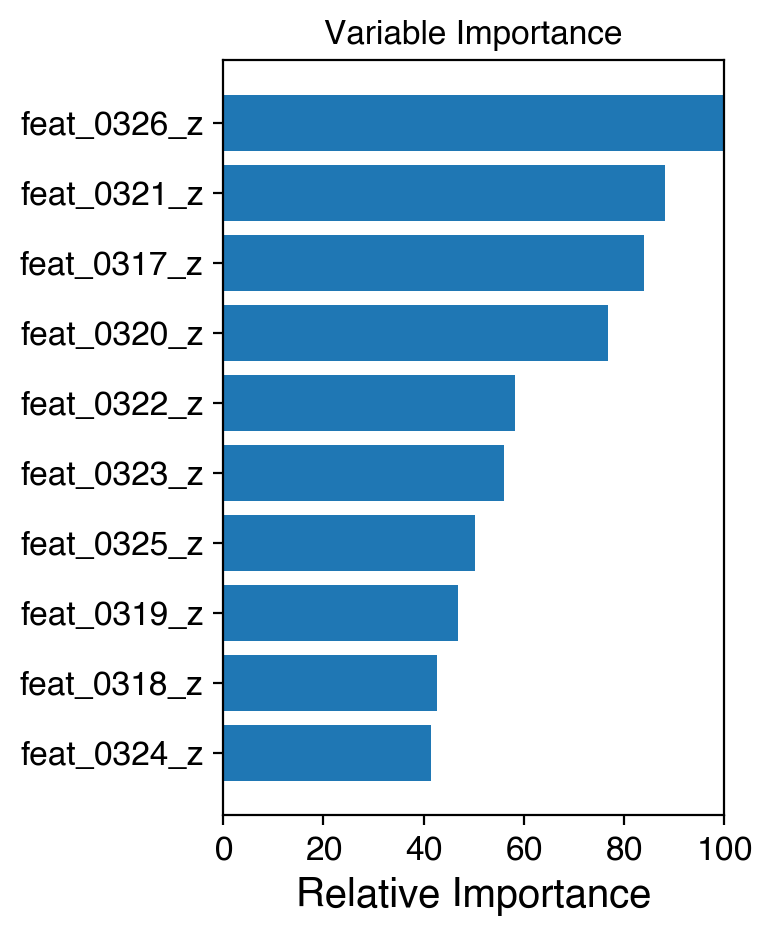

In [137]:
fig, ax = plt.subplots(figsize=(3,5))
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
ax.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx], fontsize=12)
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')